# Multi-node Search

This notebook and accompanying code shows how to run an
[Archai](https://github.com/microsoft/archai/) Neural Architecture Search (NAS) using an [Azure
Machine Learning Workspace](https://ml.azure.com/) with partial training of models (on a GPU
cluster) providing validation accuracies to guide that search. This notebook requires that you have
the [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli) installed and logged
in otherwise the create compute cluster cell will fail.  You will also need to create an Azure ML
workspace using [https://ml.azure.com] and an Azure storage account.  The storage account does not
need to be in the same resource group as the workspace.

This notebook also assumes you have a python environment setup using:

```
pip install -e .[aml] --extra-index-url https://pkgs.dev.azure.com/azure-sdk/public/_packaging/azure-sdk-for-python/pypi/simple/
```
in your Archai repository root. This example requires a `config.json` file containing the information about your
Azure subscription, the Azure ML workspace name and resource group, and the azure storage account key and name:

```json
{
    "subscription_id": "...",
    "resource_group": "...",
    "workspace_name": "...",
    "storage_account_key": "...",
    "storage_account_name": "..."
}
```
See:
- [Set up a Python development environment for Azure Machine Learning](https://learn.microsoft.com/en-us/azure/machine-learning/how-to-configure-environment#local-and-dsvm-only-create-a-workspace-configuration-file) 
- [Get your Storage Account keys](https://learn.microsoft.com/en-us/azure/storage/common/storage-account-keys-manage?tabs=azure-portal).

In [1]:
import sys
import os
import json
import archai.common.azureml_helper as aml_helper
import archai.common.notebook_helper as nb_helper
from azure.ai.ml.entities import UserIdentityConfiguration

# locate the code that we will use in this notebook.
scripts_dir = "./scripts"
data_scripts_dir = "./data_prep"

config_file = "../.azureml/config.json"
config = json.load(open(config_file, 'r'))

for required_key in ['subscription_id', 'resource_group', 'workspace_name', 'storage_account_key', 'storage_account_name']:
    if not required_key in config:
        print(f"### Error: please add a {required_key} to {config_file}")

storage_account_key = config['storage_account_key']    
storage_account_name = config['storage_account_name']
workspace_name = config['workspace_name']

print(f'Using workspace {workspace_name} and storage account: {storage_account_name}')

# This is the AML experiment name 
experiment_name = 'mnist_test_run'

Using workspace snpe-aml-workspace and storage account: archaimnistmodels


Our [search.py](scripts/search.py) will use a ConfigSearchSpace based on the following parameters, the model defined in [model.py](scripts/model.py) will take various configurations and build different shape CNN models for each configuration as shown below. Each time you execute this cell it will generate a new random CNN model.

In [2]:
from archai.discrete_search.search_spaces.config import ArchParamTree, DiscreteChoice, ArchConfig
from scripts.model import MyModel

arch_param_tree = ArchParamTree({
    'nb_layers': DiscreteChoice(list(range(1, 13))),
    'kernel_size': DiscreteChoice([1, 3, 5, 7]),
    'hidden_dim': DiscreteChoice([16, 32, 64, 128])
})

arch_config = arch_param_tree.sample_config()
print(arch_config)

MyModel(arch_config)

ArchConfig({
    "nb_layers": 5,
    "kernel_size": 3,
    "hidden_dim": 64
})


MyModel(
  (cross_entropy_loss): CrossEntropyLoss()
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): AdaptiveAvg

Get a handle to the workspace

In [3]:
ml_client = aml_helper.get_aml_client_from_file(config_path=config_file)
print(f'Using workspace "{ml_client.workspace_name}" in resource group "{ml_client.resource_group_name}"')

Found the config file in: ..\.azureml\config.json


Using workspace "snpe-aml-workspace" in resource group "snpe-aml-rg"


Create the compute clusters that we need.  If this cell fails with `DefaultAzureCredential failed to retrieve a token from the included credentials`.
then you might need to run `az login` from the command line using the [Azure CLI](https://learn.microsoft.com/en-us/cli/azure/install-azure-cli).
If it also fails with `ResourceNotFoundError: (ParentResourceNotFound)` then you may need to run `az account set --subscription ...` with the 
subscription id you specified in the above `config.json` file and check that the resource group you specified really does contain the Azure ML workspace
you specified.

In [4]:
# Create cpu cluster for running the search
cpu_compute_name = "nas-cpu-cluster-D14-v2"
aml_helper.create_compute_cluster(ml_client, cpu_compute_name, size="Standard_D14_v2", location="westus2")

# Create gpu cluster for running the search
gpu_compute_name = "nas-gpu-cluster-NC6"
aml_helper.create_compute_cluster(ml_client, gpu_compute_name, size="Standard_NC6", location="westus2", max_instances=8)

You already have a cluster named nas-cpu-cluster-D14-v2, we'll reuse it as is.
You already have a cluster named nas-gpu-cluster-NC6, we'll reuse it as is.


AmlCompute({'type': 'amlcompute', 'created_on': None, 'provisioning_state': 'Succeeded', 'provisioning_errors': None, 'name': 'nas-gpu-cluster-NC6', 'description': None, 'tags': None, 'properties': {}, 'print_as_yaml': True, 'id': '/subscriptions/c8b7f913-60fb-4759-a310-fc5630e56f99/resourceGroups/snpe-aml-rg/providers/Microsoft.MachineLearningServices/workspaces/snpe-aml-workspace/computes/nas-gpu-cluster-NC6', 'Resource__source_path': None, 'base_path': 'd:\\git\\microsoft\\archai\\archai\\docs\\advanced_guide\\cloud\\azure\\notebooks\\multi_node_search', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x00000235FFEC74C0>, 'resource_id': None, 'location': 'westus2', 'size': 'STANDARD_NC6', 'min_instances': 0, 'max_instances': 8, 'idle_time_before_scale_down': 180.0, 'identity': None, 'ssh_public_access_enabled': True, 'ssh_settings': None, 'network_settings': <azure.ai.ml.entities._compute.compute.NetworkSettings object at 0x00000235A4207D30>, 'tier'

Create the AML Environment from our conda.yaml file.  This ensures our conda environment contains the Archai framework that we are using here.

In [5]:
archai_job_env = aml_helper.create_environment_from_file(ml_client, 
                                                         image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:latest",
                                                         conda_file="conda.yaml", 
                                                         version='0.1.14')
environment_name = f"{archai_job_env.name}:{archai_job_env.version}"
print(environment_name)

Environment with name aml-archai is registered to workspace, the environment version is 0.1.14
aml-archai:0.1.14


Ensure our storage account is setup with a `models` blob store container for storing the final onnx models, a `datasets` blob store for our training dataset and a `status` storage table.

In [6]:
from archai.common.store import ArchaiStore

# Register the datastore with AML
data_store_name = "datasets"
data_container_name = "datasets"
model_store_name = "models"
model_container_name = "models"
root_folder = experiment_name

# make sure the datasets container exists
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=data_container_name)
store.upload_blob(root_folder, config_file)

# make sure the models container exists
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=model_container_name)
store.upload_blob("config", config_file)

datastore_path = f'azureml://datastores/{data_store_name}/paths/{root_folder}'
results_path = f'azureml://datastores/{model_store_name}/paths/{root_folder}'

Register the `models` blob store container in the ML workspace `datastores`

In [7]:
from azure.ai.ml.entities import AzureBlobDatastore
from azure.ai.ml.entities._credentials import AccountKeyConfiguration

try:
    model_store = ml_client.datastores.get(model_store_name)
except:    
    model_store = AzureBlobDatastore(
        name=model_store_name,
        description="Datastore pointing to our models blob container.",
        account_name=storage_account_name,
        container_name=model_container_name,
        credentials=AccountKeyConfiguration(
            account_key=storage_account_key
        ),
    )

    ml_client.create_or_update(model_store)

Register the `datasets` blob store container in the ML workspace `datastores`

In [8]:
try:
    data_store = ml_client.datastores.get(data_store_name)
except:
    data_store = AzureBlobDatastore(
        name=data_store_name,
        description="Datastore pointing to our dataset container.",
        account_name=storage_account_name,
        container_name=data_container_name,
        credentials=AccountKeyConfiguration(
            account_key=storage_account_key
        ),
    )

    ml_client.create_or_update(data_store)

Create a pipeline command that prepares our training dataset using `prep_data_store.py`.  This pipeline will write the output do our `datasets` blob store so the training jobs can find the dataset there all ready to go.  That way each training job doesn't have to repeat the download and preparation of the dataset.

In [9]:
from azure.ai.ml import command
from azure.ai.ml import Input, Output

data_prep_component = command(
    name="data_prep2",
    display_name="Data preparation for training",
    description="Downloads the remote dataset to our blob store.",  
    inputs= {
        "name": Input(type='string')
    },
    outputs= {
        "data": Output(type="uri_folder", path=datastore_path, mode="rw_mount")
    },

    # The source folder of the component
    code=data_scripts_dir,
    command="""python3 prep_data_store.py \
            --path ${{outputs.data}} \
            """,
    environment=environment_name,
)

Create a command that kicks off the Archai Search using `search.py`, it will take the dataset as input so it can pass it along to the training jobs later on.  It also produces some search output files, .png charts, and json results files which will also go into our `models` blob store under the folder named the same as our `experiment_name`.

In [10]:
hex_config = bytes(json.dumps(config), encoding='utf-8').hex()

partial_epochs = 0.1
max_unseen_population = 16  # best if this is an even multiple our gpu cluster size, we'll get much better throughput.
search_iterations = 5  # for quick debugging.
init_num_models = 10

output_path = results_path + '/' + experiment_name
fixed_args = f'--data_dir {datastore_path} ' + \
             f'--output_dir {output_path} ' + \
             f'--environment "{environment_name}" ' + \
             f'--experiment "{experiment_name}" ' + \
             f'--compute "{gpu_compute_name}" ' + \
             f'--config "{hex_config}" ' + \
             f'--search_iterations {search_iterations} ' + \
             f'--init_num_models {init_num_models} ' + \
             f'--max_unseen_population {max_unseen_population} ' + \
             f'--partial_training_epochs {partial_epochs} '

search_component = command(
    name="search",
    display_name="The Archai NAS search",
    description="Runs the NAS search algorithm.",    
    is_deterministic=False,
    inputs= {
        "data": Input(type="uri_folder")
    },
    outputs= {
        "results": Output(type="uri_folder", path=output_path, mode="rw_mount")
    },
    code=scripts_dir,
    identity= UserIdentityConfiguration(),
    command='python3 search.py --local_output ${{outputs.results}} ' + \
        fixed_args,
    environment=environment_name,
)

This creates a command that will do full training on the final list of the best models produced by the above search command. Also creates a monitor command that monitors all the parallel training jobs and gathers the results when they are all complete updating our final `models.json` file.

In [11]:
from scripts.commands import make_training_pipeline_command, make_monitor_command
full_epochs = 10
timeout = 3600
hex_config = bytes(json.dumps(config), encoding='utf-8').hex()

full_training_component = make_training_pipeline_command(
    "Full Training Pipeline", hex_config, scripts_dir, gpu_compute_name, 
    datastore_path, output_path, experiment_name, environment_name, full_epochs, save_models=True)
                                                 
monitor_component = make_monitor_command(hex_config, scripts_dir, results_path, environment_name, timeout)

Create an AML pipeline that pipes the output of the data prep to the search component, then when search is finished, starts a full training job of the top models and then waits for all that training to finish.

In [12]:
from azure.ai.ml import dsl

@dsl.pipeline(
    compute=cpu_compute_name,
    description="Archai search pipeline",
)
def archai_search_pipeline():
    
    data_prep_job = data_prep_component(
        name="MNIST"
    )

    search_job = search_component(
        data=data_prep_job.outputs.data
    )
    
    training_job = full_training_component(
        models=search_job.outputs.results,
        data=data_prep_job.outputs.data
    )

    monitor_job = monitor_component(
        models=search_job.outputs.results,
        training_results=training_job.outputs.results
    )

    return {
        "results": monitor_job.outputs.results
    }


Submit the pipeline job so it starts running in your Azure ML workspace.

In [13]:
pipeline_job = ml_client.jobs.create_or_update(
    archai_search_pipeline(),
    # Project's name
    experiment_name=experiment_name,
)

Uploading scripts (66.59 MBs): 100%|##########| 66590127/66590127 [00:22<00:00, 2904944.69it/s]




Open the pipeline azure ML studio portal in your web browser (this works when you are running this notebook in VS code).

In [14]:
import webbrowser
webbrowser.open(pipeline_job.services["Studio"].endpoint)

job_name = pipeline_job.name
print(f'Started pipeline: {job_name}')

Started pipeline: lucid_clock_927lbgy6z8


In [15]:
# you can fetch any pipeline job again if you needed to continue this notebook later:
from azure.ai.ml import dsl, Input, Output
# job_name = 'lucid_clock_927lbgy6z8'
pipeline_job = ml_client.jobs.get(job_name)

## Plots

Take a look at the pareto curve plots.  This cell can be run multiple times and you will see updates as each iteration finishes.
You can even run this later after restarting the jupyter notebook because it is not dependent on variable state it is only
dependent on the persistent 'models' blob store.

Fetching results for mnist_test_run...


Ran into a deserialization error. Ignoring since this is failsafe deserialization
Traceback (most recent call last):
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1509, in failsafe_deserialize
    return self(target_obj, data, content_type=content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1375, in __call__
    data = self._unpack_content(response_data, content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1543, in _unpack_content
    raise ValueError("This pipeline didn't have the RawDeserializer policy; can't deserialize")
ValueError: This pipeline didn't have the RawDeserializer policy; can't deserialize


Ran into a deserialization error. Ignoring since this is failsafe deserialization
Traceback (most recent call last):
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1509, in failsafe_deserialize
    return self(target_obj, data, content_type=content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1375, in __call__
    data = self._unpack_content(response_data, content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1543, in _unpack_content
    raise ValueError("This pipeline didn't have the RawDeserializer policy; can't deserialize")
ValueError: This pipeline didn't have the RawDeserializer policy; can't deserialize


Ran into a deserialization error. Ignoring since this is failsafe deserialization
Traceback (most recent call last):
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1509, in failsafe_deserialize
    return self(target_obj, data, content_type=content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1375, in __call__
    data = self._unpack_content(response_data, content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1543, in _unpack_content
    raise ValueError("This pipeline didn't have the RawDeserializer policy; can't deserialize")
ValueError: This pipeline didn't have the RawDeserializer policy; can't deserialize


Ran into a deserialization error. Ignoring since this is failsafe deserialization
Traceback (most recent call last):
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1509, in failsafe_deserialize
    return self(target_obj, data, content_type=content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1375, in __call__
    data = self._unpack_content(response_data, content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1543, in _unpack_content
    raise ValueError("This pipeline didn't have the RawDeserializer policy; can't deserialize")
ValueError: This pipeline didn't have the RawDeserializer policy; can't deserialize


Ran into a deserialization error. Ignoring since this is failsafe deserialization
Traceback (most recent call last):
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1509, in failsafe_deserialize
    return self(target_obj, data, content_type=content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1375, in __call__
    data = self._unpack_content(response_data, content_type)
  File "c:\anaconda3\envs\archai\lib\site-packages\msrest\serialization.py", line 1543, in _unpack_content
    raise ValueError("This pipeline didn't have the RawDeserializer policy; can't deserialize")
ValueError: This pipeline didn't have the RawDeserializer policy; can't deserialize


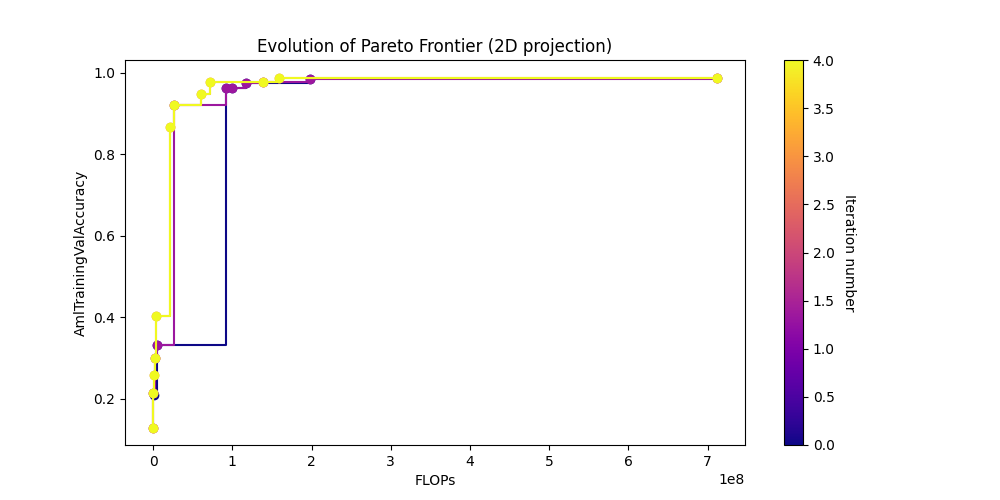

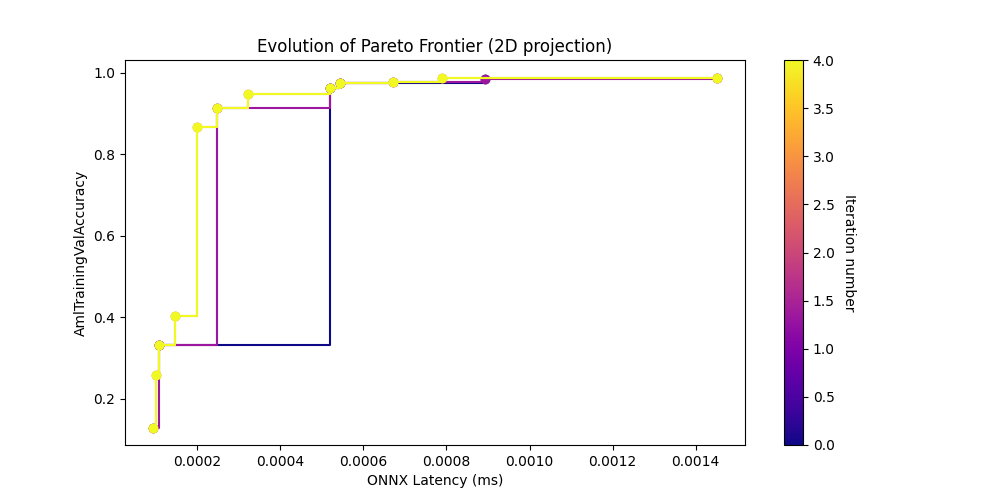

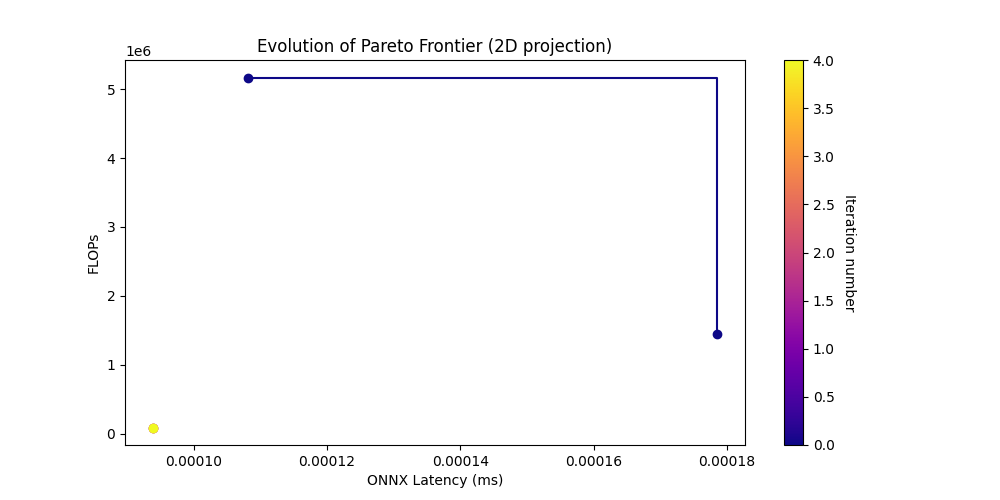

In [20]:
from scripts.utils import get_results, show_results, download_best_models
from archai.common.store import ArchaiStore
store = ArchaiStore(storage_account_name, storage_account_key, blob_container_name=model_container_name)

print(f'Fetching results for {experiment_name}...')
blob_path = root_folder + '/' + experiment_name
output_folder = experiment_name

get_results(store, blob_path, output_folder)
download_best_models(store, experiment_name, output_folder)
show_results(output_folder)

In [21]:
from IPython.display import display
from IPython.core.display import HTML

df = nb_helper.get_search_csv(output_folder)
df = df.drop('parent', axis=1)
df = df.drop('parents', axis=1)

csv_as_html = nb_helper.get_csv_as_stylized_html(df)
display(HTML(csv_as_html))

,archid,AmlTrainingValAccuracy,ONNX Latency (ms),FLOPs,iteration_num,search_walltime_hours,is_pareto
0,210e69e2747f166859b1f50833b84eefc24c8f81,0.984400,0.000534,242827402.000000,0,0.141538,True
1,781f6db586b52471d12e036a1f1134cea4b40ec9,0.969700,0.000362,160137354.000000,0,0.141538,False
2,8b0140dbdce869bd1f06def5e837c88c8944f6c7,0.964800,0.000311,87883914.000000,0,0.141538,True
3,95ff7a18e530838311190db8a08e7340bd83c63d,0.202700,0.000132,1442890.000000,0,0.141538,False
4,4875099993ba2b2cbbc6146a115a08680bac4b9e,0.270200,0.000082,690250.000000,0,0.141538,True
5,38ff94d7d8aaae60f8ed8022f551aa536506366a,0.987800,0.001407,949883146.000000,0,0.141538,False
6,d69728e8a6d52dabbf30d6819a0871dc1c9453ac,0.976200,0.000308,116985994.000000,0,0.141538,True
7,65c17a87e5e2f06ec7aff7e3e940d0c41f286137,0.299400,0.000082,2584714.000000,0,0.141538,True
8,42076d5008a44f65c8abac537aa8adf85dcb0a55,0.798900,0.000186,18603082.000000,0,0.141538,True
9,60a82c9b513aa366028b4223d1b19cf669e4d0ef,0.528600,0.000125,10775626.000000,0,0.141538,True


## Test ONNX Runtime Inference on the Best Model

When the search pipeline completes you should have a `models.json` file in the experiment_name output folder and you can use that to find the most accurate model and run it through the ONNX runtime to see if the ONNX inference gets the same accuracy.

In [22]:
# find the top model in the json results.
filename = os.path.join(output_folder, "models.json")
best_of_the_best = None
top_accuracy = -1
row = None
if not os.path.isfile(filename):
    raise Exception(f"Could not find {filename} file. Please wait for job to finish.")

results = json.load(open(filename, "r"))
models = results['models']
for a in models:
    if type(a) is dict and 'val_acc' in a:
        val_acc = a['val_acc']
        if val_acc > top_accuracy:
            top_accuracy = val_acc
            best_of_the_best = a['id']
            row = a

model = MyModel(ArchConfig(row))

arch = f"nb_layers={model.nb_layers}, kernel_size={model.kernel_size}, hidden_dim={model.hidden_dim}"
print(f"The top model is {best_of_the_best} with accuracy {top_accuracy} and architecture {arch}")

blob_path = root_folder + '/' + best_of_the_best
model_output = os.path.join(output_folder, 'top_model')
get_results(store, blob_path, model_output)

model_path = os.path.join(model_output, 'model.onnx')


The top model is id_33cef334_c8d4_42b4_a252_5b0582910907 with accuracy 0.9861999750137329 and architecture nb_layers=9, kernel_size=7, hidden_dim=16


data has shape: torch.Size([28, 28])


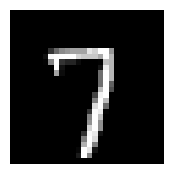

input: input, [1, 1, 28, 28], tensor(float)
Testing 10000 rows


c:\anaconda3\envs\archai\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Failed 100 out of 10000 rows
Inference pass rate is  99.0 %.
How does this compare with the training validation accuracy of 0.9861999750137329
The onnx runtime is giving different results.


In [23]:
# Great, now let's test if this model works as advertised.
from archai.datasets.cv.mnist_dataset_provider import MnistDatasetProvider
import onnxruntime as ort
import numpy as np

dataset_provider = MnistDatasetProvider()
val_data = dataset_provider.get_val_dataset()
count = val_data.data.shape[0]
test = np.random.choice(count, 1)[0]
data = val_data.data[test]

import matplotlib.pyplot as plt

# check what the images look like.
plt.figure(figsize=(2,2))
plt.imshow(data, cmap='gray')
print(f'data has shape: {data.shape}')
plt.axis('off')
plt.show()

# Now run the ONNX runtime on this the validation set.
# You can change this to `CUDAExecutionProvider` if you have a GPU and have
# installed the CUDA runtime.
ort_sess = ort.InferenceSession(model_path, providers=['CPUExecutionProvider'])
for i in ort_sess.get_inputs():
    print(f'input: {i.name}, {i.shape}, {i.type}')
    
print(f'Testing {count} rows')
failed = 0
for i in range(val_data.data.shape[0]):
    data = val_data.data[i]    
    expected = int(val_data.train_labels[i])

    while len(data.shape) < 4:
        data = np.expand_dims(data, axis=0)
    outputs = ort_sess.run(None, {'input': data.astype(np.float32) / 255.0})
    result = outputs[0]
    index = np.argmax(result)
    label = val_data.classes[index]
    if expected != index:
        # print(f'### Failed: {expected} and got {label}')
        failed += 1
          
rate = (count - failed) * 100 / count
print(f"Failed {failed} out of {count} rows")
print(f'Inference pass rate is  {rate} %.')
print(f'How does this compare with the training validation accuracy of {top_accuracy}')
if np.isclose(rate, top_accuracy* 100, atol=0.1):
    print('Success! The model is working as expected.')
else:
    print('The onnx runtime is giving different results.')
